<a href="https://colab.research.google.com/github/Shashank-Holla/TSAI-EVA6-Phase1/blob/main/07-%20Advanced%20Concepts/CIFAR10_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification on Cifar10 dataset

## Objective:


## Observations:



## Necessary packages

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, utils
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
!pip install -U -q git+https://github.com/albu/albumentations --no-cache-dir
# print('Albumentations version:',albumentations.__version__)

In [2]:
from CIFAR10 import cifar10
from albumentation_transform import *
from utils import *
from test import *
from train import *
from cifar_model import *

## Visualize data

In [3]:
viz_data = cifar10(root='./data', train=True, download=True, transform=None)
classes = viz_data.classes

Files already downloaded and verified


In [4]:
print("Classes of CIFAR10 dataset", classes)

Classes of CIFAR10 dataset ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
print(dataset_calculate_mean_std())

Files already downloaded and verified
Files already downloaded and verified
([0.24697121432552785, 0.24338893940435022, 0.2615925905215076], [0.4918687788500817, 0.4826539051649305, 0.44717727749693625])


In [6]:
mean=[0.4919, 0.4827, 0.4472]
stddev=[0.2470, 0.2434, 0.2616]

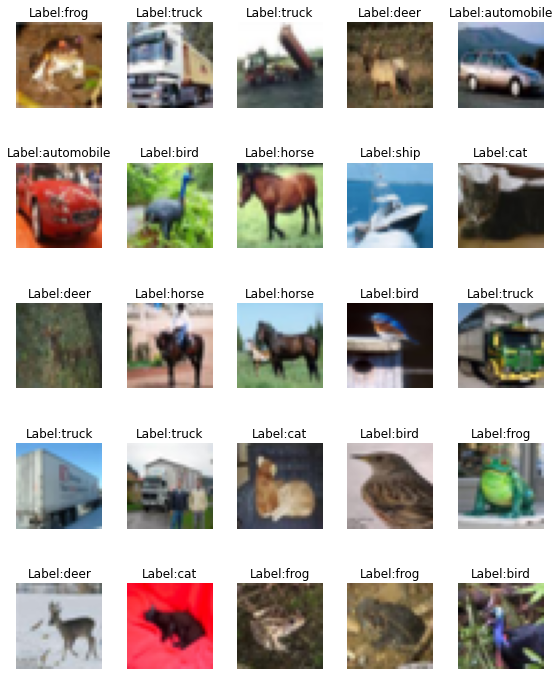

In [7]:
visualize_data(viz_data,classes)

## Prepare dataset, apply transform and prepare Dataloader

In [8]:
train_transform = albumentation_transform(train=True, mean=mean, stddev=stddev)
test_transform = albumentation_transform(train=False, mean=mean, stddev=stddev)

In [9]:
train_dataset = cifar10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = cifar10(root='./data', train=False, download=True, transform=test_transform)
batch_size = 128
kwargs = {'num_workers': 2, 'pin_memory': True}
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
sample_images, sample_labels = next(iter(train_loader))

In [11]:
sample_images.shape

torch.Size([128, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 133, 133])


(-0.5, 132.5, 132.5, -0.5)

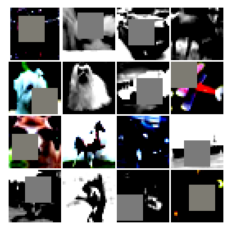

In [12]:
grid_image = utils.make_grid(sample_images[:16], nrow=4, padding=1, pad_value=1)
print(grid_image.shape)
plt.imshow(grid_image.permute(1,2,0))
plt.axis('off')

## Model

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available device:",device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

Available device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]              81
              ReLU-2            [-1, 3, 32, 32]               0
       BatchNorm2d-3            [-1, 3, 32, 32]               6
            Conv2d-4            [-1, 3, 32, 32]              27
            Conv2d-5           [-1, 64, 32, 32]             192
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
            Conv2d-8            [-1, 3, 32, 32]              81
              ReLU-9            [-1, 3, 32, 32]               0
      BatchNorm2d-10            [-1, 3, 32, 32]               6
           Conv2d-11           [-1, 64, 32, 32]           4,288
             ReLU-12           [-1, 64, 32, 32]               0
      BatchNorm2d-13           [-1, 64, 32, 32]             128
           Conv2

In [14]:
EPOCHS = 75
train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []
l1_lambda=0
l2_lambda=0

# Optimization algorithm from torch.optim
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=l2_lambda)
# Loss condition
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True, threshold=0.001, cooldown=0, min_lr=1e-4)

for epochs in range(EPOCHS):
    print(f"Epoch: {epochs}")
    train_acc_delta, train_loss_delta = train(model, device, train_loader, optimizer, criterion, l1_lambda)
    test_acc_delta, test_loss_delta = test(model, device, test_loader, criterion)
    scheduler.step(test_loss_delta)

    train_accuracy.append(round(train_acc_delta, 2))
    train_loss.append(round(train_loss_delta, 4))
    test_accuracy.append(round(test_acc_delta, 2))
    test_loss.append(round(test_loss_delta, 4))

Epoch: 0
Train set: Epoch Accuracy: 35.31  Epoch Loss: 1.7689
Test set: Epoch Accuracy: 46.07  Epoch Loss: 1.4647
Epoch: 1
Train set: Epoch Accuracy: 46.12  Epoch Loss: 1.4874
Test set: Epoch Accuracy: 55.35  Epoch Loss: 1.2461
Epoch: 2
Train set: Epoch Accuracy: 52.77  Epoch Loss: 1.3294
Test set: Epoch Accuracy: 58.77  Epoch Loss: 1.1878
Epoch: 3
Train set: Epoch Accuracy: 56.73  Epoch Loss: 1.2217
Test set: Epoch Accuracy: 63.93  Epoch Loss: 1.0158
Epoch: 4
Train set: Epoch Accuracy: 59.33  Epoch Loss: 1.1486
Test set: Epoch Accuracy: 66.9  Epoch Loss: 0.9353
Epoch: 5
Train set: Epoch Accuracy: 61.67  Epoch Loss: 1.0924
Test set: Epoch Accuracy: 67.91  Epoch Loss: 0.9074
Epoch: 6
Train set: Epoch Accuracy: 62.95  Epoch Loss: 1.0476
Test set: Epoch Accuracy: 70.49  Epoch Loss: 0.8554
Epoch: 7
Train set: Epoch Accuracy: 64.22  Epoch Loss: 1.0122
Test set: Epoch Accuracy: 70.47  Epoch Loss: 0.8522
Epoch: 8
Train set: Epoch Accuracy: 65.27  Epoch Loss: 0.9848
Test set: Epoch Accuracy: 7

## Results

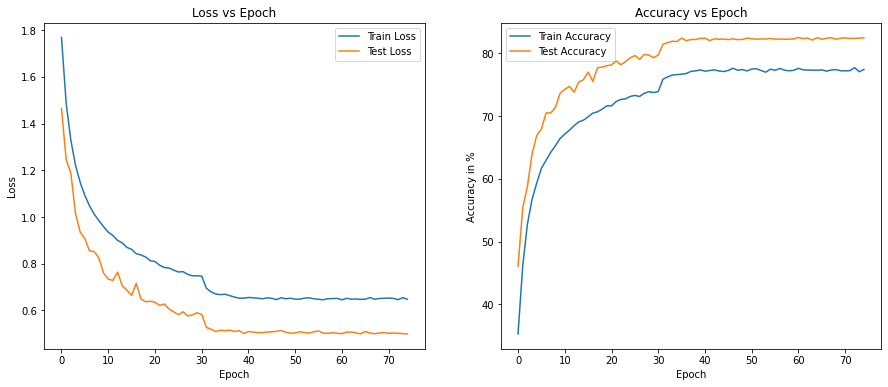

<Figure size 432x288 with 0 Axes>

In [15]:
draw_loss_accuracy_graph(train_loss, test_loss, train_accuracy, test_accuracy)

### Misclassified Images

In [16]:
label_incorrect, prediction_incorrect, images_incorrect = capture_incorrect_classified_samples(model, device, test_loader)

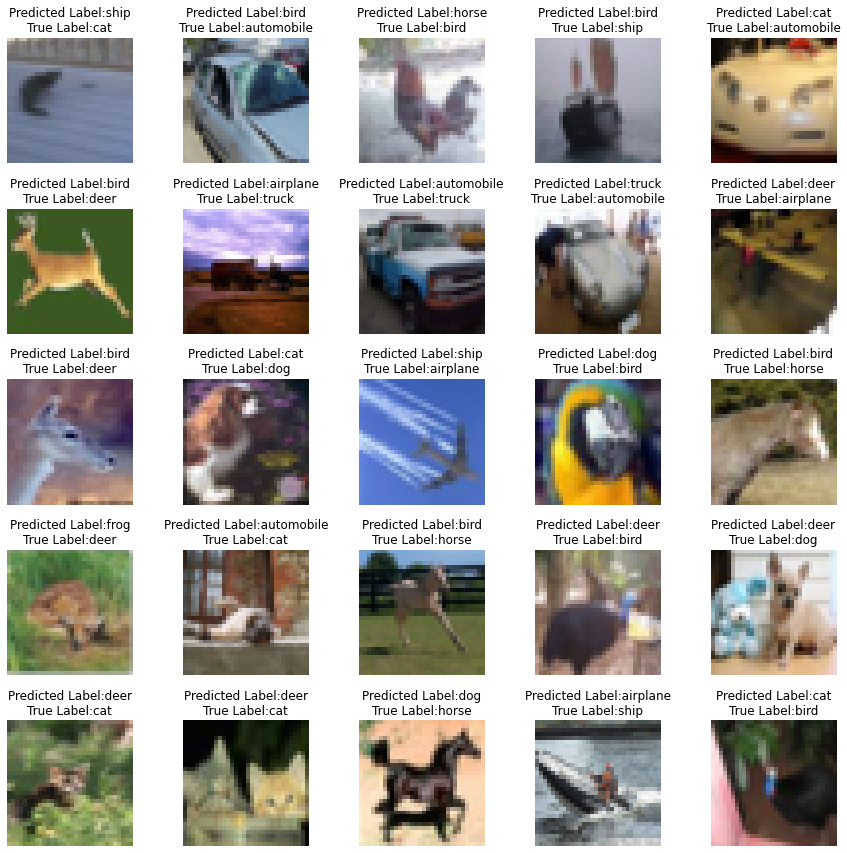

In [17]:
denormalized_images = denormalize(images_incorrect, mean, stddev)
show_incorrect_images(label_incorrect, prediction_incorrect, denormalized_images, classes)